In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
from confpred.cp import run_cp
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import pickle

/Users/margaridacampos/.pyenv/versions/3.11.6/envs/entmaxcp/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset_list = ['CIFAR10','ImageNet','CIFAR100','NewsGroups']
seed = '23'
model_loss = 'softmax'
alpha_list = np.round(np.linspace(0.01,0.1,10),4)
score_list = ['limit','opt_entmax','RAPS','sparsemax','softmax','entmax']
random_states = [1,12,123,1234,12345]
all_res_class_df = pd.DataFrame()
for alpha in alpha_list:
    for random_state in random_states:
        for dataset in dataset_list:
            for score in score_list:
                with open(f'../data/set_prediction/{dataset}_{score}_{seed}_{random_state}_alpha{alpha}_test_pred.pickle', 'rb') as handle:
                    test_preds = pickle.load(handle)
                path = f'../data/predictions/{dataset}_{seed}_test_true.pickle'
                with open(path, 'rb') as f:
                    test_true_enc_og = pickle.load(f)
                
                cal_size = np.ceil(test_true_enc_og.shape[0]*0.4).astype(int)
                test_true_enc = shuffle(test_true_enc_og,random_state = random_state)
                cal_true_enc = test_true_enc[0:cal_size]
                test_true_enc = test_true_enc[cal_size:]


                #test_match = test_pvalues>alpha
                test_match = test_preds
                set_size = test_match.sum(axis=1)
                test_bool = test_match[test_true_enc.astype(bool)]

                set_size_res = pd.DataFrame({'dataset':dataset,
                            'score':score,
                            'alpha':alpha,
                            'random_state':random_state,
                            'set_size':set_size,
                            'match':test_bool})
                all_res_class_df = pd.concat([all_res_class_df,set_size_res])

In [3]:
summary_results = all_res_class_df.groupby(['dataset','score','alpha','random_state']).mean().reset_index()
summary_results.rename(columns = {'match':'coverage','set_size':'avg_size'},inplace=True)
summary_results['name'] = summary_results['score'].map({'RAPS':'RAPS',
                                                        'sparsemax':'sparsemax',
                                                        'opt_entmax':'opt-entmax',
                                                        'softmax':'InvProb',      
                                                        'limit':'log-margin',   
                                                        'entmax':'1.5-entmax'
                                                    },na_action="ignore")

In [4]:
all_res_class_df['size_bin'] = pd.cut(all_res_class_df['set_size'],bins = [0,1,3,6,10,np.inf])
all_res_class_df['order'] = all_res_class_df['score'].map({'RAPS':1,
                                                        'sparsemax':4,
                                                        'opt_entmax':5,
                                                        'softmax':0,      
                                                        'limit':2,   
                                                        'entmax':3
                                                    },na_action="ignore")
all_res_class_df.sort_values(by='order',inplace=True)
all_res_class_df['score'] = all_res_class_df['score'].map({'RAPS':'RAPS',
                                                        'sparsemax':'sparsemax',
                                                        'opt_entmax':'opt-entmax',
                                                        'softmax':'InvProb',      
                                                        'limit':'log-margin',   
                                                        'entmax':'1.5-entmax'
                                                    },na_action="ignore")

In [5]:
def get_table_bin_size(random_state,dataset,alpha):
    grouped_df = all_res_class_df.groupby(['dataset','score','alpha','random_state','size_bin'])[['match']].agg(['mean','count'])
    grouped_df_temp = grouped_df.reset_index().droplevel(1,axis=1)
    selected_df = grouped_df_temp[(grouped_df_temp['dataset']==dataset)&(grouped_df_temp['random_state']==random_state)&(grouped_df_temp['alpha']==alpha)]\
        .drop(columns=['dataset','random_state','alpha'])
    selected_df.columns = ['score','size_bin','coverage','count']
    print(f'Datset:{dataset}, Random State:{random_state}, Alpha:{alpha}')
    return selected_df.pivot(columns='score',index=['size_bin']).swaplevel(0, 1, axis=1).sort_index(axis=1)


In [6]:
get_table_bin_size(1,'NewsGroups',0.1).round(3)

/var/folders/q2/bjm3n1qd6jq1npksrk9n26nw0000gn/T/ipykernel_18773/4079458646.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_df = all_res_class_df.groupby(['dataset','score','alpha','random_state','size_bin'])[['match']].agg(['mean','count'])


Datset:NewsGroups, Random State:1, Alpha:0.1


score       1.5-entmax          InvProb           RAPS          log-margin  \
                 count coverage   count coverage count coverage      count   
size_bin                                                                     
(0.0, 1.0]        1356    0.933    1481    0.918  1114    0.943       1481   
(1.0, 3.0]         471    0.885     320    0.856   299    0.936        312   
(3.0, 6.0]         208    0.837     121    0.868   787    0.850        113   
(6.0, 10.0]        102    0.833      92    0.946    61    0.525         77   
(10.0, inf]        124    0.944     247    0.964     0      NaN        278   

score                opt-entmax          sparsemax           
            coverage      count coverage     count coverage  
size_bin                                                     
(0.0, 1.0]     0.918       1226    0.939       575    0.967  
(1.0, 3.0]     0.853        642    0.894      1336    0.912  
(3.0, 6.0]     0.867        234    0.786       263    0.722  
(6.0, 10.0]    0.961         92    0.793        27    0.778  
(10.0, inf]    0.975         67    0.985        60    0.883

In [7]:
singleton_df = all_res_class_df[all_res_class_df['random_state']==1]
singleton_df['is_singleton'] = singleton_df['set_size']==1
singleton_df = singleton_df.groupby(['dataset','score','alpha'])[['is_singleton']].mean().join(singleton_df[singleton_df['is_singleton']].groupby(['dataset','score','alpha'])[['match']].mean()).reset_index()
singleton_df['name'] = singleton_df['score']

/var/folders/q2/bjm3n1qd6jq1npksrk9n26nw0000gn/T/ipykernel_18773/683390258.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  singleton_df['is_singleton'] = singleton_df['set_size']==1


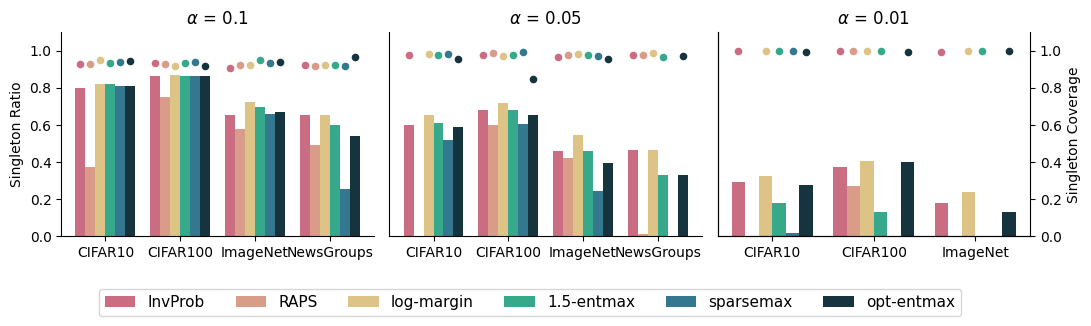

In [9]:
plt.rcParams['pdf.fonttype'] = 42

# Custom color map dictionary
color_map = {
    'InvProb': '#da5c7a',    # Red
    'RAPS': '#e5957c',       # Orange
    'log-margin': '#ecc979', # Yellow
    '1.5-entmax': '#22bc93', # Teal
    'sparsemax': '#24809e',  # Blue
    'opt-entmax': '#103743'  # Dark blue
}

legend_labels = ['InvProb', 'RAPS', 'log-margin', '1.5-entmax', 'sparsemax', 'opt-entmax']

fig, axs = plt.subplots(1, 3, figsize=(12.5, 3))

for i, alpha in enumerate([0.1, 0.05, 0.01]):
    alp = singleton_df[singleton_df['alpha'] == alpha].dropna(subset=['match'])  # Drop NaNs in match

    # Plot bars
    barplot = sns.barplot(data=alp, x='dataset', y='is_singleton', hue='name', 
                          hue_order=legend_labels, palette=color_map, ax=axs[i], dodge=True)
    axs[i].set_title(r'$\alpha$ = ' + str(alpha))

    # Extract x-positions and colors from bars
    bar_positions = {}
    for bar, (dataset, name) in zip(barplot.patches, zip(alp['dataset'], alp['name'])):
        x_pos = bar.get_x() + bar.get_width() / 2  # Center of the bar
        bar_positions[(dataset, name)] = (x_pos, bar.get_facecolor())

    # Scatter points
    for name in legend_labels:
        subset = alp[alp['name'] == name]
        for dataset, match_value in zip(subset['dataset'], subset['match']):
            if (dataset, name) in bar_positions:
                x_pos, color = bar_positions[(dataset, name)]
                axs[i].scatter(x_pos, match_value, color=color, zorder=3, s=20)

    # Remove subplot legends
    axs[i].get_legend().remove()
    axs[i].set_xlabel('')
    axs[i].set_ylabel('')
    axs[i].set_ylim(0, 1.1)
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)

# Extract legend only from barplot
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=6, bbox_to_anchor=(0.5, 0.05), fontsize=11)

# Y-axis adjustments
axs[0].set_ylabel('Singleton Ratio')
axs[1].set_yticks([])
axs[2].set_yticks([])
ax2 = axs[2].twinx()
ax2.spines['top'].set_visible(False)
ax2.set_ylabel("Singleton Coverage")
ax2.set_ylim(0, 1.1)
plt.subplots_adjust(bottom=0.2, wspace=0.05, hspace=0.4)
plt.show()


In [10]:
temp_df = all_res_class_df[all_res_class_df['random_state']==1]
sscv_df = temp_df.groupby(['dataset','score','alpha','size_bin'])[['match']].agg(['mean','count']).reset_index()
sscv_df.columns = list(map(''.join, sscv_df.columns.values))
sscv_df = sscv_df[sscv_df['matchcount']>1]
sscv_df['error'] = np.abs(sscv_df['matchmean']-(1-sscv_df['alpha']))
sscv_df.sort_values(by='error',ascending=False,inplace=True)
sscv_df = sscv_df.groupby(['dataset','score','alpha']).head(1)
sscv_df = sscv_df[sscv_df['alpha'].isin([0.01,0.05,0.1])]
sscv_df.sort_values(by=['dataset','score','alpha'],inplace=True)

/var/folders/q2/bjm3n1qd6jq1npksrk9n26nw0000gn/T/ipykernel_18773/668859908.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sscv_df = temp_df.groupby(['dataset','score','alpha','size_bin'])[['match']].agg(['mean','count']).reset_index()


/var/folders/q2/bjm3n1qd6jq1npksrk9n26nw0000gn/T/ipykernel_18773/714011113.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1].legend().set_visible(False)
/var/folders/q2/bjm3n1qd6jq1npksrk9n26nw0000gn/T/ipykernel_18773/714011113.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[2].legend(title='')
/var/folders/q2/bjm3n1qd6jq1npksrk9n26nw0000gn/T/ipykernel_18773/714011113.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[2].legend(title='')


Text(0, 0.5, 'SSCV')

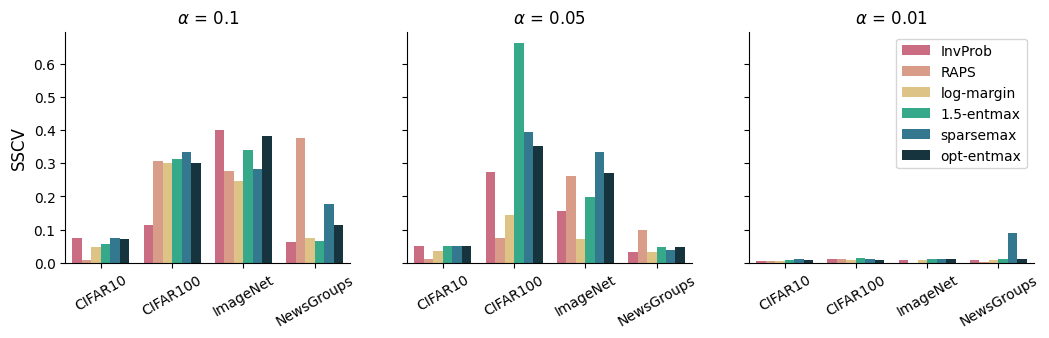

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(12.5, 3),sharey=True)
for i, alpha in enumerate([0.1, 0.05, 0.01]):
    alp = sscv_df[sscv_df['alpha'] == alpha]#.dropna(subset=['match'])  # Drop NaNs in match

    # Plot bars
    barplot = sns.barplot(data=alp, x='dataset', y='error', hue='score', 
                          hue_order=legend_labels, palette=color_map, ax=axs[i], dodge=True)
    axs[i].set_title(r'$\alpha$ = ' + str(alpha))
    axs[i].spines[['right', 'top']].set_visible(False)
    axs[i].set_xlabel('')
    axs[i].tick_params(axis='x', labelrotation = 30)
    axs[0].legend().set_visible(False)
    axs[1].legend().set_visible(False)
    axs[2].legend(title='')
axs[0].set_ylabel('SSCV',fontsize=12)